# Local Outlier Factor

In [1]:
## just for debug
import os, sys
ROOT_PATH = os.path.dirname(os.getcwd())
if ROOT_PATH not in sys.path: sys.path.insert(1,str(ROOT_PATH))
ROOT_PATH

'e:\\dherrera\\OneDrive - Universidad Tecnológica de Bolívar\\TesisAnomDetect'

In [2]:
random_state = 123
scoring_metric = "roc_auc"
dataset_name="heart_faliure"
contamination = 0.1

Load librerias

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from lib_anomaly.utils import load_dataset

... Loading: lib_anomaly.models
... Loading: lib_anomaly.utils


Load data

In [4]:
data, target = load_dataset(dataset_name=dataset_name, random_state=random_state, ROOT_PATH=ROOT_PATH)
data.head()

,heartdisease,heartdiseaseLabel,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope
349,1,Heart Disease,36,M,ASY,110,0,1,Normal,125,Y,1.0,Flat
653,0,Normal,42,M,NAP,130,180,0,Normal,150,N,0.0,Up
7,0,Normal,54,M,ATA,110,208,0,Normal,142,N,0.0,Up
571,1,Heart Disease,69,M,ASY,140,110,1,Normal,109,Y,1.5,Flat
171,0,Normal,40,M,NAP,140,235,0,Normal,188,N,0.0,Up


In [5]:
features = list(data.columns)[2:]
print(f"{target=}\nNo features={len(features)} -> {features}\n{data.shape=}")


target='heartdisease'
No features=11 -> ['age', 'sex', 'chestpaintype', 'restingbp', 'cholesterol', 'fastingbs', 'restingecg', 'maxhr', 'exerciseangina', 'oldpeak', 'st_slope']
data.shape=(918, 13)


make `X` and `y`

In [6]:
X = data.drop([target, target+"Label"], axis=1).copy()
y = data[target].copy()
print(f"{X.shape=}\n{y.shape=}\n\n{target=} distribution")
print(pd.DataFrame(
    [dict(y.value_counts().sort_index())
    , dict(y.value_counts(normalize=True).sort_index()*100)
    ]
    , index=["freq","%"]
).T.to_string())
X.head()

X.shape=(918, 11)
y.shape=(918,)

target='heartdisease' distribution
    freq          %
0  410.0  44.662309
1  508.0  55.337691


,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope
349,36,M,ASY,110,0,1,Normal,125,Y,1.0,Flat
653,42,M,NAP,130,180,0,Normal,150,N,0.0,Up
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up
571,69,M,ASY,140,110,1,Normal,109,Y,1.5,Flat
171,40,M,NAP,140,235,0,Normal,188,N,0.0,Up


Preprocess

In [7]:
from lib_anomaly.utils import fix_data_type

from sklearn.pipeline           import Pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import MinMaxScaler, OneHotEncoder
from sklearn.compose            import ColumnTransformer
from category_encoders.binary   import BinaryEncoder

In [8]:
data, cols_num, cols_cat_high, cols_cat_low = fix_data_type(
                                    features=features
                                    , data=data
                                )
print(f"{cols_num=}\n{cols_cat_high=}\n{cols_cat_low=}")

cols_num=['age', 'restingbp', 'cholesterol', 'fastingbs', 'maxhr', 'oldpeak']
cols_cat_high=[]
cols_cat_low=['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope']


In [9]:
## pipeline
process_num = Pipeline(steps=[
                        ("impute_mean", SimpleImputer(missing_values=np.nan, strategy="median")),
                        ("scale_minmax", MinMaxScaler((0,1)))
                    ]
                )
process_low_cat = Pipeline(steps=[
                        ("impute_constant", SimpleImputer(missing_values=np.nan, strategy="most_frequent"))
                        , ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
                    ]
                )
process_high_cat = Pipeline(steps=[
                        ("impute_constant", SimpleImputer(missing_values=np.nan, strategy="most_frequent"))
                        , ("binary", BinaryEncoder())
                        , ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))       ##agregado posterior
                    ]
                )
preprocess_vars = ColumnTransformer(
                    [
                        ("cat_low_dimension", process_low_cat, cols_cat_low)
                        , ("cat_high_dimension", process_high_cat, cols_cat_high)
                        , ("numerical", process_num, cols_num)
                    ]
            )
preprocess_vars

ColumnTransformer(transformers=[('cat_low_dimension',
                                 Pipeline(steps=[('impute_constant',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'chestpaintype', 'restingecg',
                                  'exerciseangina', 'st_slope']),
                                ('cat_high_dimension',
                                 Pipeline(steps=[('impute_constant',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder()),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 []),
                                ('numerical',
                                 Pipeline(steps=[('impute_mean',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale_minmax',
                                                  MinMaxScaler())]),
                                 ['age', 'restingbp', 'cholesterol',
                                  'fastingbs', 'maxhr', 'oldpeak'])])

In [10]:
preprocess_vars.fit(X)
X_ = preprocess_vars.transform(data[features])
print(f"{X_.shape=}")

X_.shape=(918, 20)


Split

In [11]:
from sklearn.model_selection    import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
                                                    X_
                                                    , y
                                                    , test_size=0.1
                                                    , stratify=y
                                                    , random_state=random_state
                                                )
print(f"{x_train.shape=}, {x_test.shape=}, {y_train.shape=}, {y_test.shape=}")

x_train.shape=(826, 20), x_test.shape=(92, 20), y_train.shape=(826,), y_test.shape=(92,)


Realizar clasificacion

In [13]:
from sklearn.model_selection    import cross_val_score, cross_val_predict, StratifiedKFold
from lib_anomaly.models         import load_classifiers_models, get_metrics_report
from lib_anomaly.plots          import plot_metrics

... Loading: lib_anomaly.plots


In [14]:
Before = dict()
classifiers = load_classifiers_models()
pBar = tqdm(classifiers.items())
for name,clf in pBar:
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
    pBar.set_description(name)
    score = cross_val_score(
                            estimator=clf
                            , X=x_train
                            , y=y_train
                            , scoring=scoring_metric
                            , cv=cv
                        )
    y_pred = cross_val_predict(
                            estimator=clf
                            , X=x_train
                            , y=y_train
                            , cv=cv
                )
    cla_report = get_metrics_report(y_true=y_train, y_pred=y_pred)
    cla_report.update({f"cv_{scoring_metric}_mean":score.mean(),f"cv_{scoring_metric}_std":score.std()})
    # resp[name] = {"mean":score.mean(), "std":score.std()}
    Before[name] = cla_report

AB: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it] 


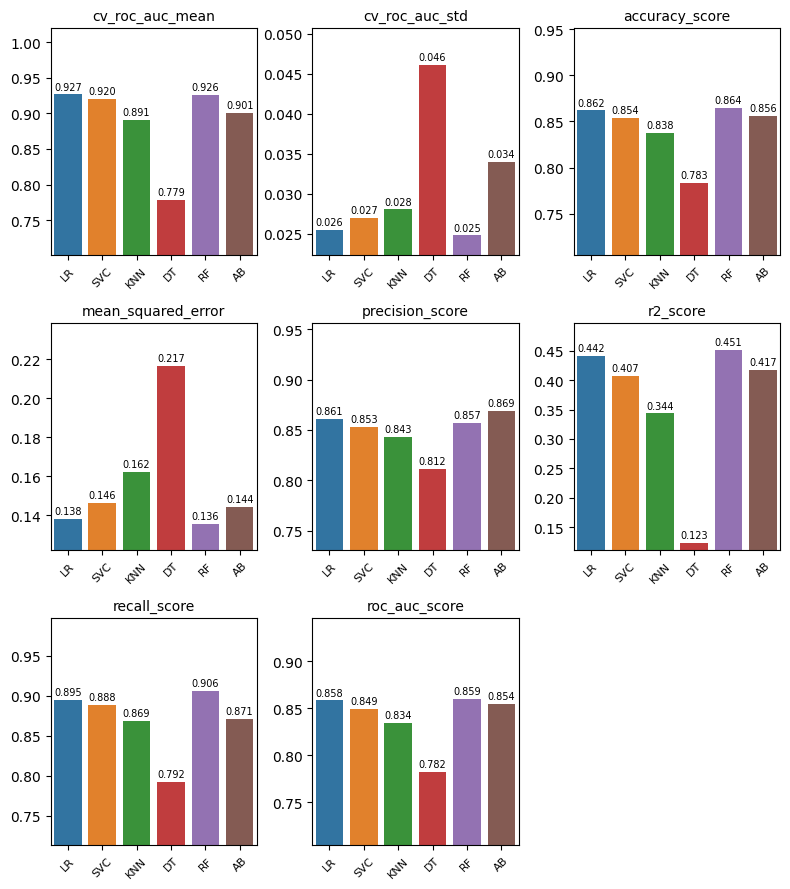

In [15]:
plot_metrics(
            results=Before
            , ncol=3
            , show_title=False
            # , out_path=out_path
            # , fName="metrics_before"
        )

Autoencoders from pyod

In [16]:
from pyod.models.lof import LOF

In [17]:
print(f"{contamination=}")

contamination=0.1


In [18]:
%%time
detector = LOF(contamination=contamination)
detector.fit(X_)

CPU times: total: 969 ms
Wall time: 182 ms


LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [19]:
anom            = detector.labels_
res_decision    = detector.decision_function(X_)
proba           = detector.predict_proba(X_)

In [20]:
print(f"No of anomaly = {sum(anom)} {round(sum(anom)/len(anom)*100,4)}%")
tmp = pd.DataFrame(anom, columns=["anom"])
dict(tmp.value_counts()), dict(tmp.value_counts(normalize=True))
pd.concat([tmp.head(10).reset_index(), tmp.tail(10).reset_index()], axis=1)

No of anomaly = 92 10.0218%


,index,anom,index,anom
0,0,0,908,0
1,1,0,909,0
2,2,0,910,0
3,3,0,911,0
4,4,0,912,0
5,5,0,913,0
6,6,0,914,0
7,7,0,915,0
8,8,0,916,0
9,9,0,917,0


In [21]:
norm_index = [i for i,a in enumerate(anom) if a==0]
anom_index = [i for i,a in enumerate(anom) if a==1]
print(f"{norm_index[:20]=}")
print(f"{anom_index[:20]=}")

norm_index[:20]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
anom_index[:20]=[26, 41, 48, 68, 104, 115, 117, 119, 133, 134, 136, 139, 146, 162, 185, 189, 216, 218, 220, 225]


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

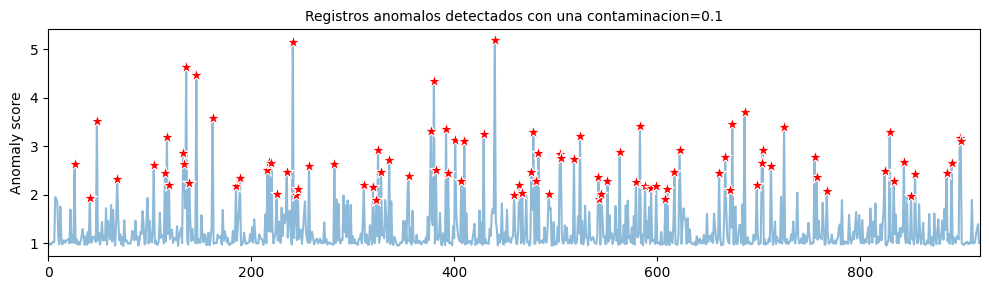

In [23]:
plt.figure(figsize=(10,3))
g = sns.lineplot(x=range(len(res_decision)), y=res_decision, zorder=0, alpha=0.5)
g = sns.scatterplot(x=anom_index, y=res_decision[anom_index], color="red", zorder=1, marker="*", s=100)
g.set(xlim=(0,len(res_decision)), ylabel="Anomaly score")
plt.title(f"Registros anomalos detectados con una contaminacion={contamination}", size=10)
plt.tight_layout()
plt.show()

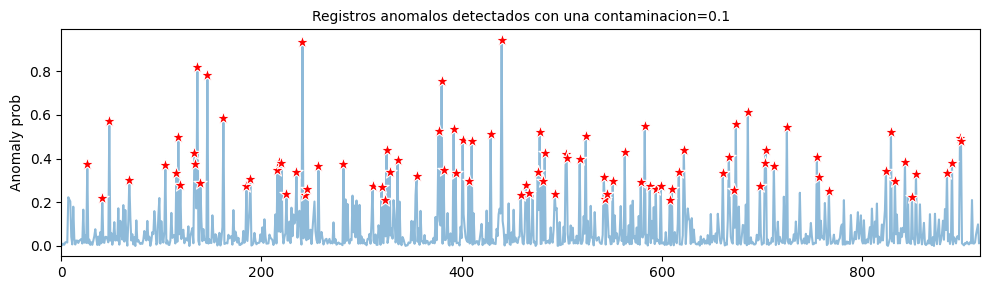

In [24]:
## plot de anomalias por probabilidad
plt.figure(figsize=(10,3))
g = sns.lineplot(x=range(len(proba)), y=proba[:,1], zorder=0, alpha=0.5)
g = sns.scatterplot(x=anom_index, y=proba[:,1][anom_index], color="red", zorder=1, marker="*", s=100)
g.set(xlim=(0,len(res_decision)), ylabel="Anomaly prob")
plt.title(f"Registros anomalos detectados con una contaminacion={contamination}", size=10)
plt.tight_layout()
plt.show()

In [25]:
X_A,y_A, = X_[norm_index],y.iloc[norm_index]
print(f"{X_A.shape=}\n{y_A.shape=}\n\n{target=} distribution")
print(pd.DataFrame(
    [dict(y_A.value_counts().sort_index())
    , dict(y_A.value_counts(normalize=True).sort_index()*100)
    ]
    , index=["freq","%"]
).T.to_string())

X_A.shape=(826, 20)
y_A.shape=(826,)

target='heartdisease' distribution
    freq          %
0  345.0  41.767554
1  481.0  58.232446


In [26]:
x_trainA, x_testA, y_trainA, y_testA = train_test_split(
                                                    X_A
                                                    , y_A
                                                    , test_size=0.1
                                                    , stratify=y_A
                                                    , random_state=random_state
                                                )
print(f"{x_trainA.shape=}, {x_testA.shape=}, {y_trainA.shape=}, {y_testA.shape=}")

x_trainA.shape=(743, 20), x_testA.shape=(83, 20), y_trainA.shape=(743,), y_testA.shape=(83,)


In [27]:
After = dict()

pBar = tqdm(classifiers.items())
for name,clf in pBar:
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
    pBar.set_description(name)
    scoreA = cross_val_score(
                            estimator=clf
                            , X=x_trainA
                            , y=y_trainA
                            , scoring=scoring_metric
                            , cv=cv
                        )
    y_predA = cross_val_predict(
                            estimator=clf
                            , X=x_trainA
                            , y=y_trainA
                            , cv=cv
                )
    cla_reportA = get_metrics_report(y_true=y_trainA, y_pred=y_predA)
    cla_reportA.update({f"cv_{scoring_metric}_mean":scoreA.mean(),f"cv_{scoring_metric}_std":scoreA.std()})
    # resp[name] = {"mean":score.mean(), "std":score.std()}
    After[name] = cla_reportA

AB: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it] 


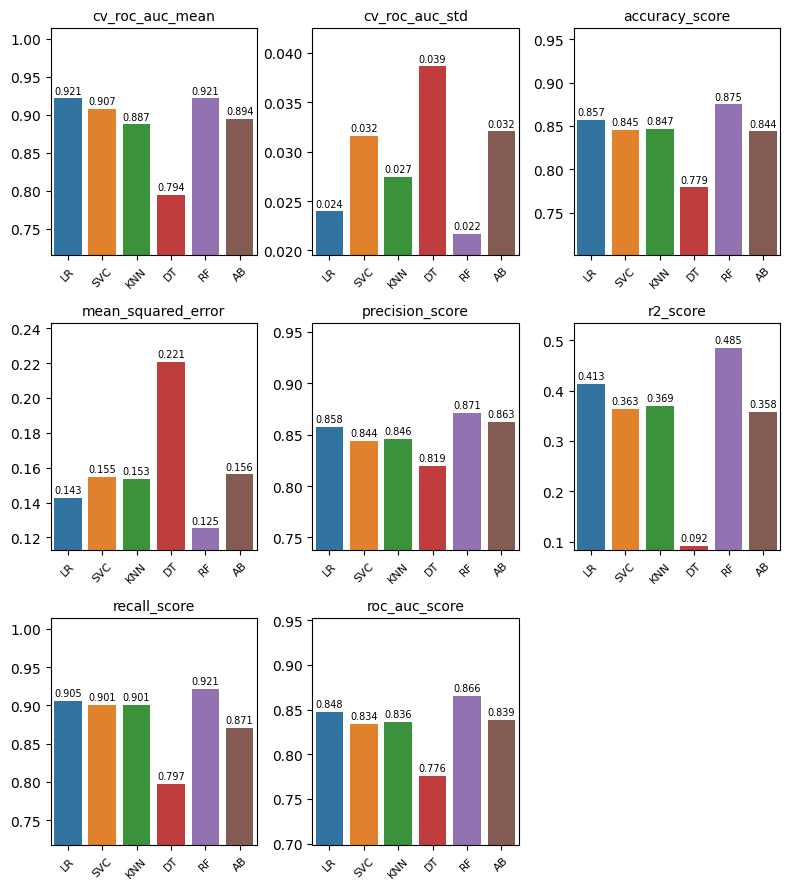

In [28]:
plot_metrics(
            results=After
            , ncol=3
            , show_title=False
            # , out_path=out_path
            # , fName="metrics_before"
        )

In [29]:
from lib_anomaly.plots import plot_comparacion_resultados

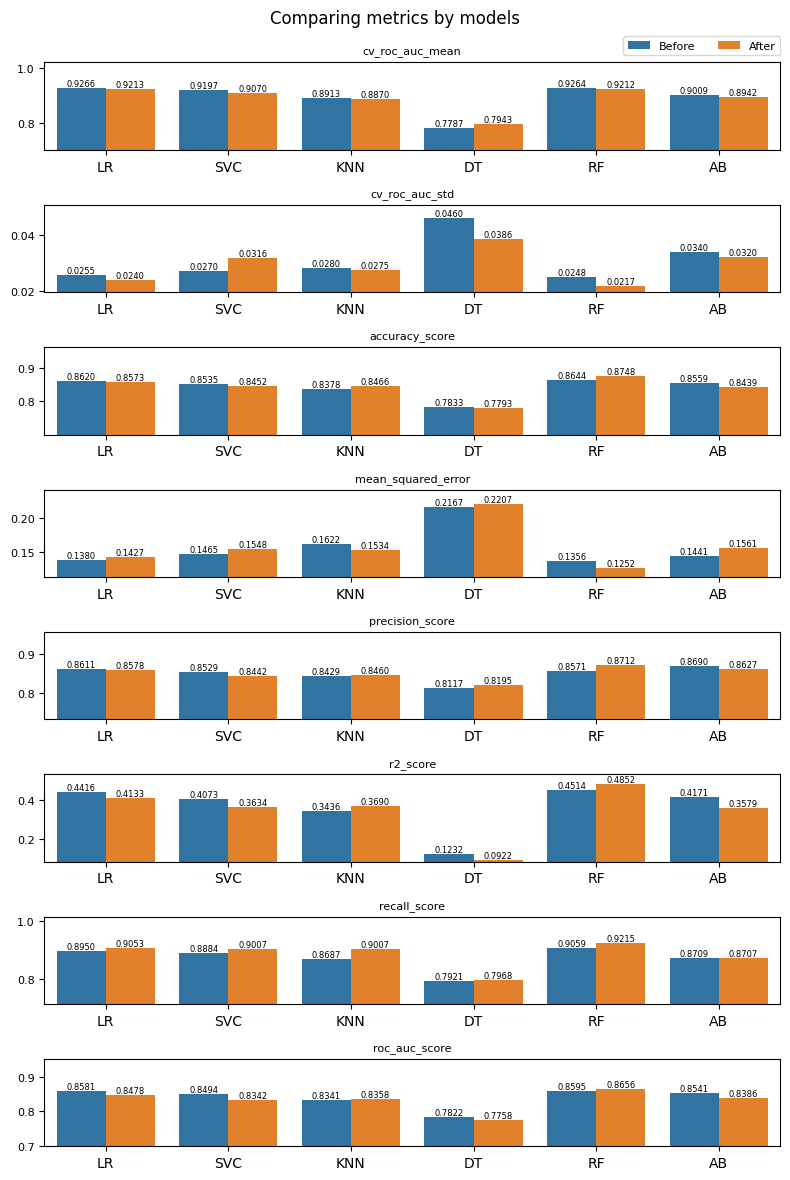

In [30]:

plot_comparacion_resultados(
                    linea_base=Before
                    , experimento=After
                )